In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

## EDA

Tình hình là data được hợp bởi 2 cái API về weather và air quality từ Weatherbit.

Bộ weather từ **2020-01-01** đến **2025-11-01**, bộ air quality từ **2022-01-14** đến **2025-11-01**.

Có thể dùng đa phần feature của final dataset để train, trừ một vài cái bị multicollinearity hay leakage thì ae bỏ ra là được tuỳ model. Ae tua đến cái correlation matrix đọc cho nhanh :))))

In [2]:
df = pd.read_csv('combined_climate_data.csv')
print(df.columns)

Index(['lat', 'lon', 'timestamp', 'temp', 'pres', 'humidity', 'clouds',
       'wind_spd', 'wind_dir', 'wind_gust_spd', 'uv', 'precip', 'dewpt', 'aqi',
       'pm25', 'pm10', 'o3', 'so2', 'no2', 'co'],
      dtype='object')


In [3]:
unique_locations = df[['lat', 'lon']].drop_duplicates()
print(unique_locations)
print(f"\nTotal unique locations: {len(unique_locations)}")

             lat         lon
0       20.96700  105.767000
51194   21.00513  105.841531
102388  21.03300  105.833000
153582  21.03300  105.850000
204776  21.22100  105.807000

Total unique locations: 5


In [4]:
# Chọn 1 trạm để plot thôi
def df_loc_filtered(df, locs):
    mask = np.zeros(len(df), dtype=bool)
    for lat, lon in locs:
        mask |= (np.isclose(df['lat'], lat) & np.isclose(df['lon'], lon))
    new_df = df.copy()
    new_df = df[mask].reset_index(drop=True)
    return new_df

new_df = df_loc_filtered(df, locs=[(21.00513, 105.841531)])
print(new_df.describe())


                lat           lon          temp          pres      humidity  \
count  5.119400e+04  51194.000000  51193.000000  51193.000000  51193.000000   
mean   2.100513e+01    105.841531     25.083728   1009.867326     77.734358   
std    3.552748e-15      0.000000      5.580550      7.191540     15.368581   
min    2.100513e+01    105.841531      7.000000    983.000000     17.000000   
25%    2.100513e+01    105.841531     21.100000   1004.000000     68.000000   
50%    2.100513e+01    105.841531     25.800000   1009.000000     82.000000   
75%    2.100513e+01    105.841531     29.000000   1015.000000     90.000000   
max    2.100513e+01    105.841531     40.200000   1033.000000    100.000000   

             clouds      wind_spd      wind_dir  wind_gust_spd            uv  \
count  51193.000000  51193.000000  51193.000000   51193.000000  51193.000000   
mean      69.568437      1.875441    188.897466       4.594570      1.288395   
std       31.379311      0.891707     99.474509 

In [5]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Temporal features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month_name()
df['day_of_week'] = df['timestamp'].dt.day_name()
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

# Define custom order for categorical plots
day_order = list(calendar.day_name)
aqi_order = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
month_order = list(calendar.month_name)[1:]

print(day_order, month_order)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [6]:
def get_aqi_category(aqi):
    """Returns the textual category for a given AQI value (US Standard)."""
    if aqi is None or np.isnan(aqi):
        return None
    
    val = int(aqi)
    if val <= 50: return "Good"
    if val <= 100: return "Moderate"
    if val <= 150: return "Unhealthy for Sensitive Groups"
    if val <= 200: return "Unhealthy"
    if val <= 300: return "Very Unhealthy"
    return "Hazardous"

df['aqi_category'] = df['aqi'].apply(get_aqi_category)

print(df['aqi_category'].describe())

count       166680
unique           6
top       Moderate
freq         66445
Name: aqi_category, dtype: object


In [7]:
df.to_csv('data/weatherbit_final.csv', index=False)


Percentage of hours in each category:
Good: 2.3%
Moderate: 26.0%
Unhealthy for Sensitive Groups: 18.3%
Unhealthy: 13.0%
Very Unhealthy: 5.3%
Hazardous: 0.3%


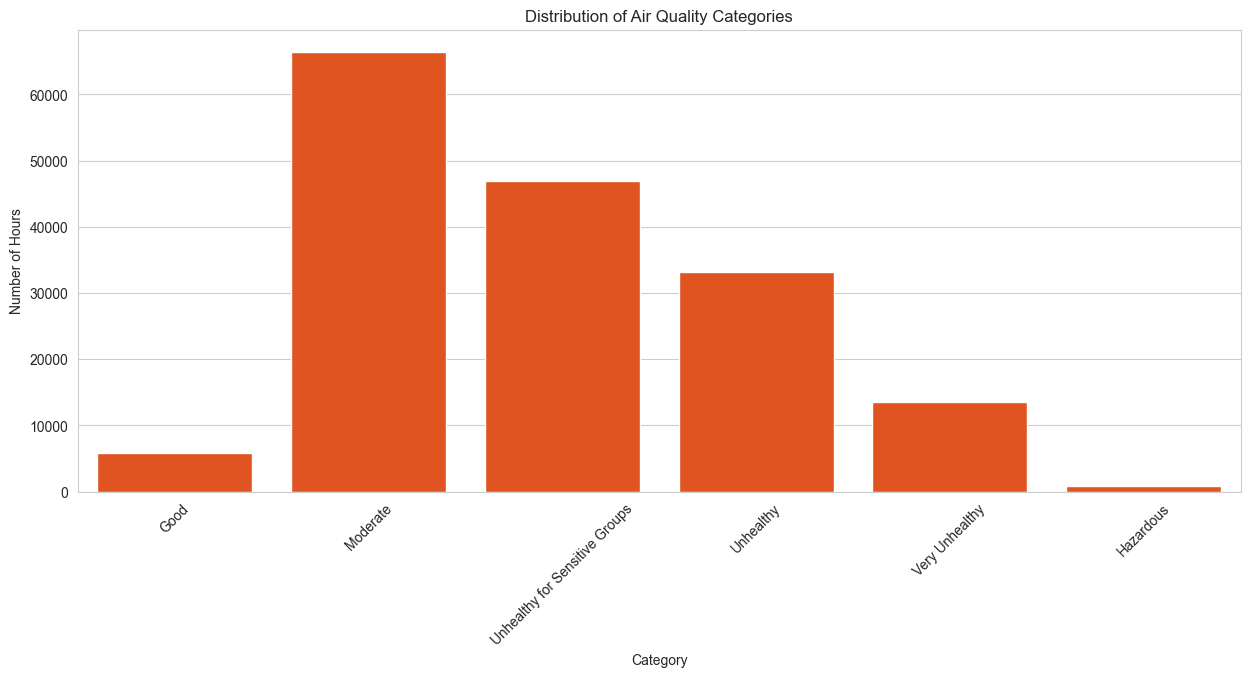

In [8]:
plt.figure(figsize=(15, 6))

# Countplot of AQI Categories
sns.countplot(data=df, x='aqi_category', order=aqi_order, color='orangered')

plt.title('Distribution of Air Quality Categories')
plt.xticks(rotation=45)
plt.ylabel('Number of Hours')
plt.xlabel('Category')

# Calculate percentages
total = len(df)
counts = df['aqi_category'].value_counts()
print("\nPercentage of hours in each category:")
for cat in aqi_order:
    if cat in counts:
        print(f"{cat}: {counts[cat]/total*100:.1f}%")

plt.show()

### Temporal features

In [9]:
df_dhbk = df_loc_filtered(df, locs=[(21.00513, 105.841531)])

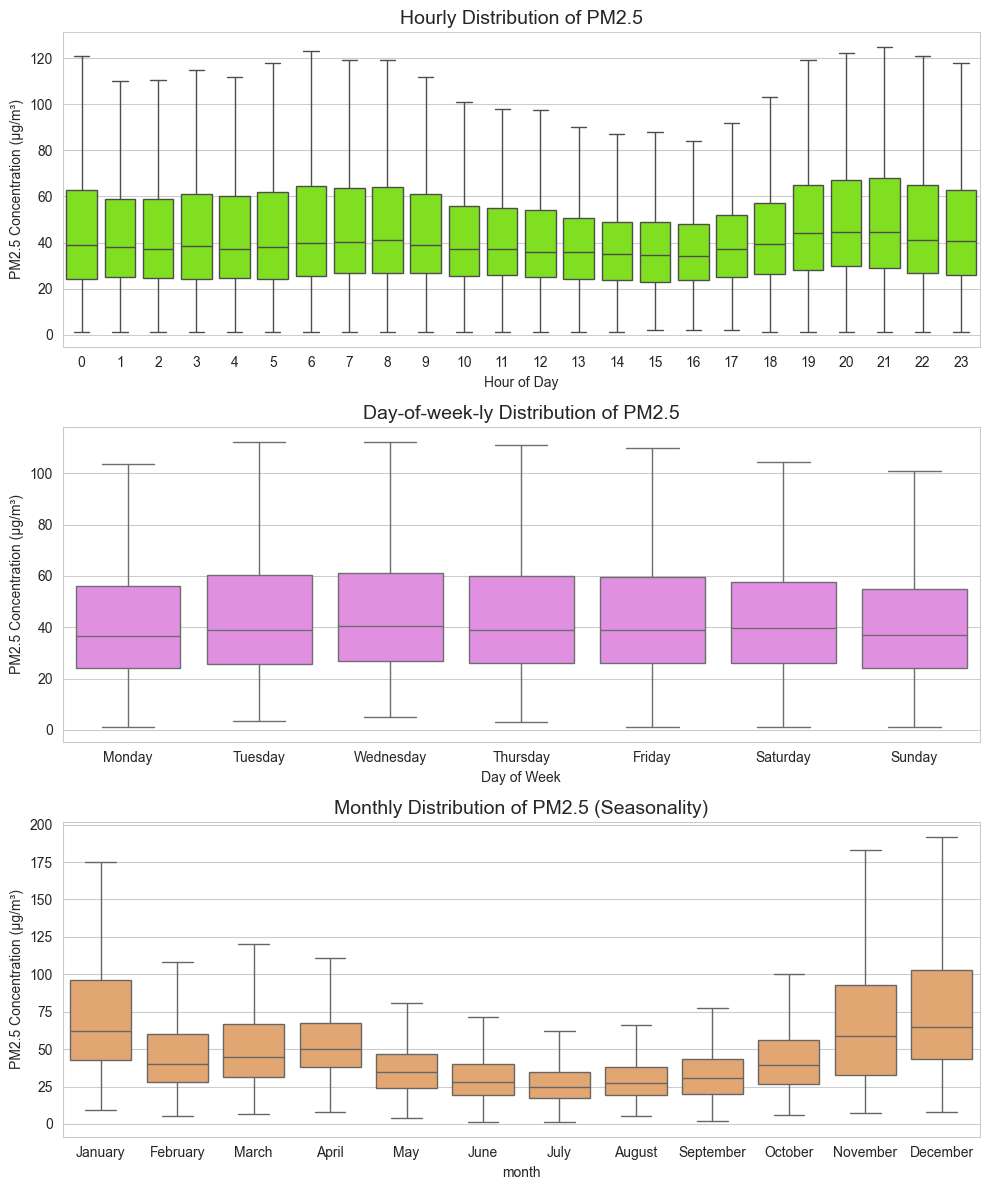

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# PM2.5 Distribution by Hour
sns.boxplot(data=df_dhbk, x='hour', y='pm25', ax=axes[0], color='chartreuse', showfliers=False)
axes[0].set_title('Hourly Distribution of PM2.5', fontsize=14)
axes[0].set_ylabel('PM2.5 Concentration (µg/m³)')
axes[0].set_xlabel('Hour of Day')

# PM2.5 Distribution by Day of Week
sns.boxplot(data=df_dhbk, x='day_of_week', y='pm25', order=day_order, ax=axes[1], color='violet', showfliers=False)
axes[1].set_title('Day-of-week-ly Distribution of PM2.5', fontsize=14)
axes[1].set_ylabel('PM2.5 Concentration (µg/m³)')
axes[1].set_xlabel('Day of Week')

# PM2.5 Distribution by Month
sns.boxplot(data=df_dhbk, x='month', y='pm25', order=month_order, ax=axes[2], color='sandybrown', showfliers=False)
axes[2].set_title('Monthly Distribution of PM2.5 (Seasonality)', fontsize=14)
axes[2].set_ylabel('PM2.5 Concentration (µg/m³)')

plt.tight_layout()
plt.show()

Apparent U-shaped pattern for Hour of Day. Why? Just my speculation:
- AM and PM rushes around 6 and 17 *supposedly* raise PM2.5 concentration. Not really evident at AM, but more noticeable at PM.
- Noon and early afternoon: Sun warms the air and disperses pollutant, traffic eases.
- Night: temperature drop - trapped air, little decline.

But whether it's warm or wet or not, much depends on the season. The monthly distribution seems to confirm the sun/warm theory.

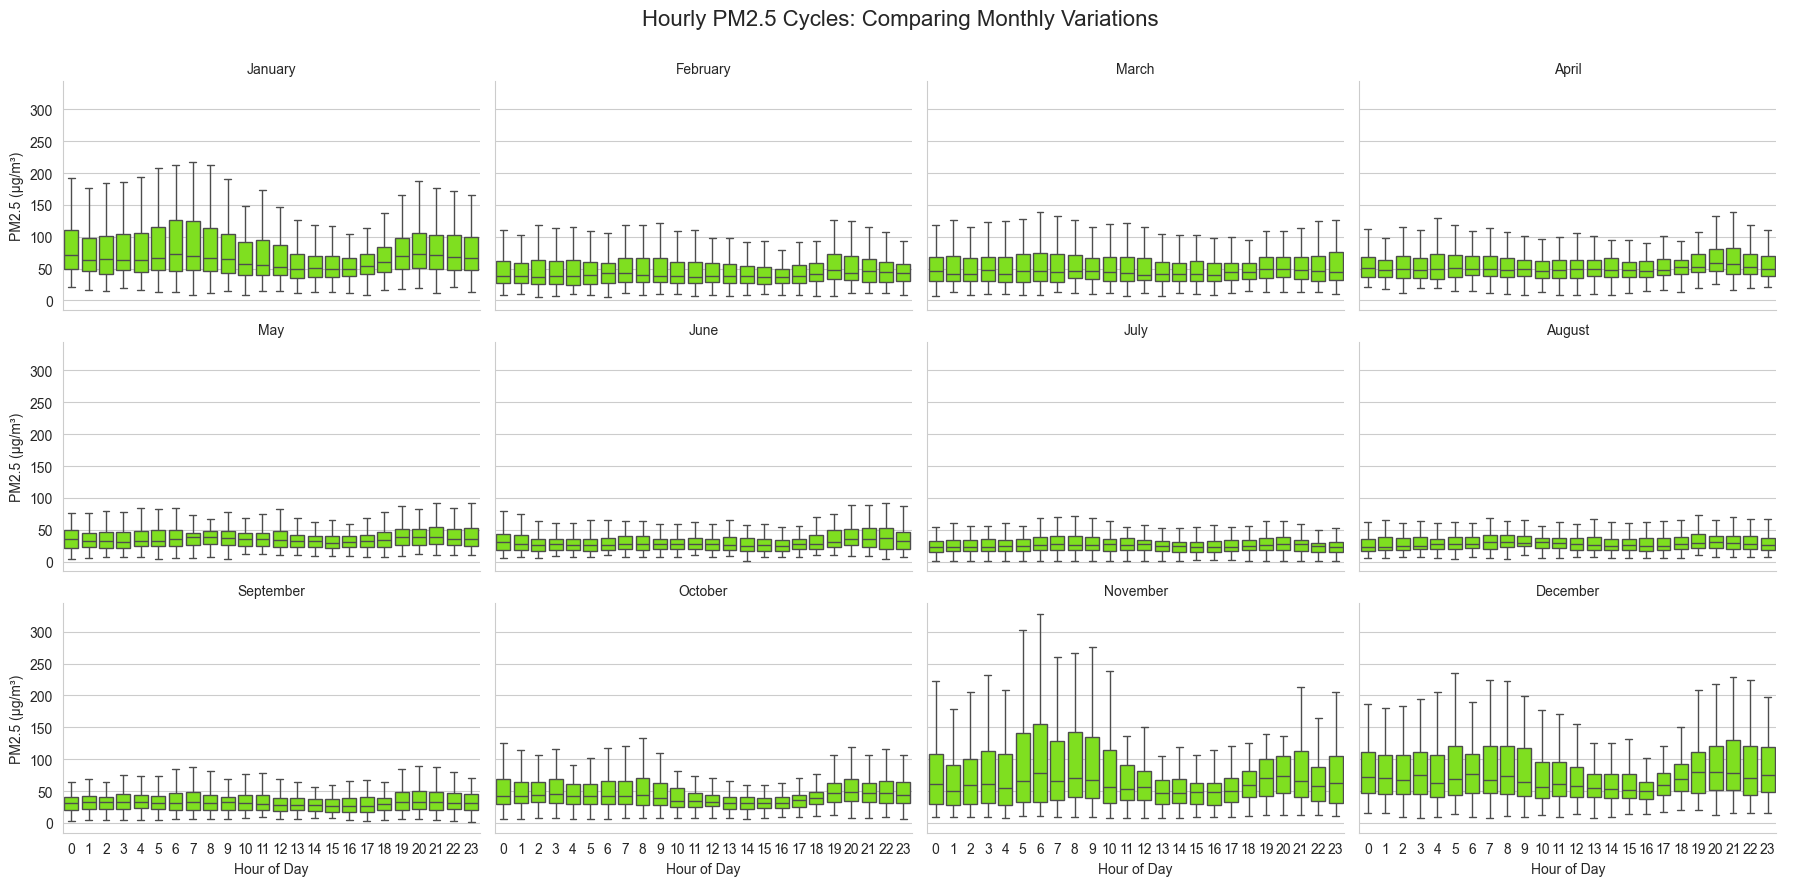

In [11]:
g = sns.catplot(
    data=df_dhbk,
    x='hour',
    y='pm25',
    col='month',
    col_order=month_order,
    col_wrap=4,
    kind='box',
    color='chartreuse',
    showfliers=False,
    height=3,
    aspect=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels("Hour of Day", "PM2.5 (µg/m³)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Hourly PM2.5 Cycles: Comparing Monthly Variations', fontsize=16)

plt.show()

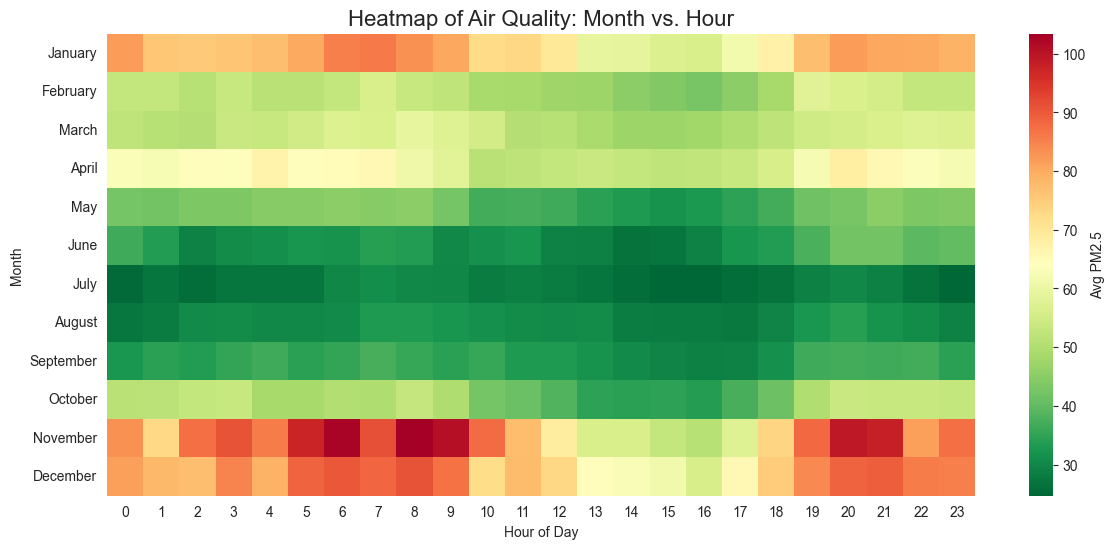

In [12]:
pivot_table = df_dhbk.pivot_table(values='pm25', index='month', columns='hour', aggfunc='mean')
pivot_table = pivot_table.reindex(month_order)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='RdYlGn_r', annot=False, cbar_kws={'label': 'Avg PM2.5'})
plt.title('Heatmap of Air Quality: Month vs. Hour', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.yticks(rotation=0) 
plt.show()

Hell yeah! The U-shape is much more pronounced during not-so-warm seasons and flattens during summer months.

**Conclusion:** PM2.5 does vary with Hour of Day depending on the season. Summer observes low value and low variance of concentration.

### Weather features

In [13]:
print(df_dhbk.columns)

Index(['lat', 'lon', 'timestamp', 'temp', 'pres', 'humidity', 'clouds',
       'wind_spd', 'wind_dir', 'wind_gust_spd', 'uv', 'precip', 'dewpt', 'aqi',
       'pm25', 'pm10', 'o3', 'so2', 'no2', 'co', 'hour', 'month',
       'day_of_week', 'is_weekend', 'aqi_category'],
      dtype='object')


In [14]:
cols = ['temp', 'pres', 'humidity', 'clouds',
        'wind_spd', 'wind_dir', 'wind_gust_spd', 'uv',
        'precip', 'dewpt', 'aqi',
       'pm25', 'pm10', 'o3', 'so2', 'no2', 'co']
print(df_dhbk[cols].describe())

               temp          pres      humidity        clouds      wind_spd  \
count  51193.000000  51193.000000  51193.000000  51193.000000  51193.000000   
mean      25.083728   1009.867326     77.734358     69.568437      1.875441   
std        5.580550      7.191540     15.368581     31.379311      0.891707   
min        7.000000    983.000000     17.000000      0.000000      0.000000   
25%       21.100000   1004.000000     68.000000     50.000000      1.200000   
50%       25.800000   1009.000000     82.000000     77.000000      2.000000   
75%       29.000000   1015.000000     90.000000    100.000000      2.330000   
max       40.200000   1033.000000    100.000000    100.000000     12.400000   

           wind_dir  wind_gust_spd            uv        precip         dewpt  \
count  51193.000000   51193.000000  51193.000000  51193.000000  51193.000000   
mean     188.897466       4.594570      1.288395      0.304208     20.554404   
std       99.474509       2.114752      1.869115

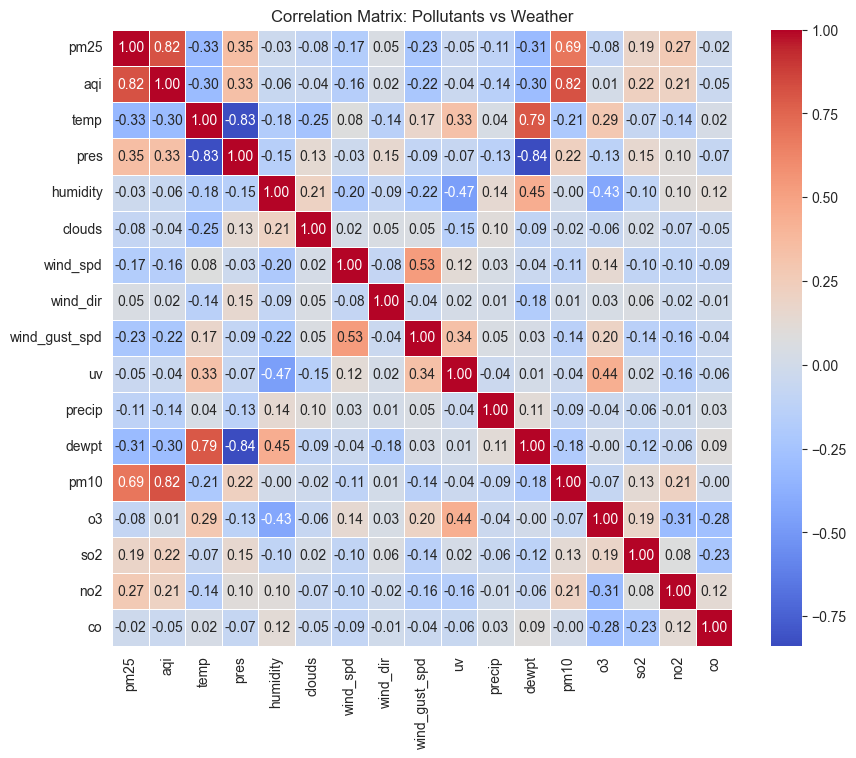

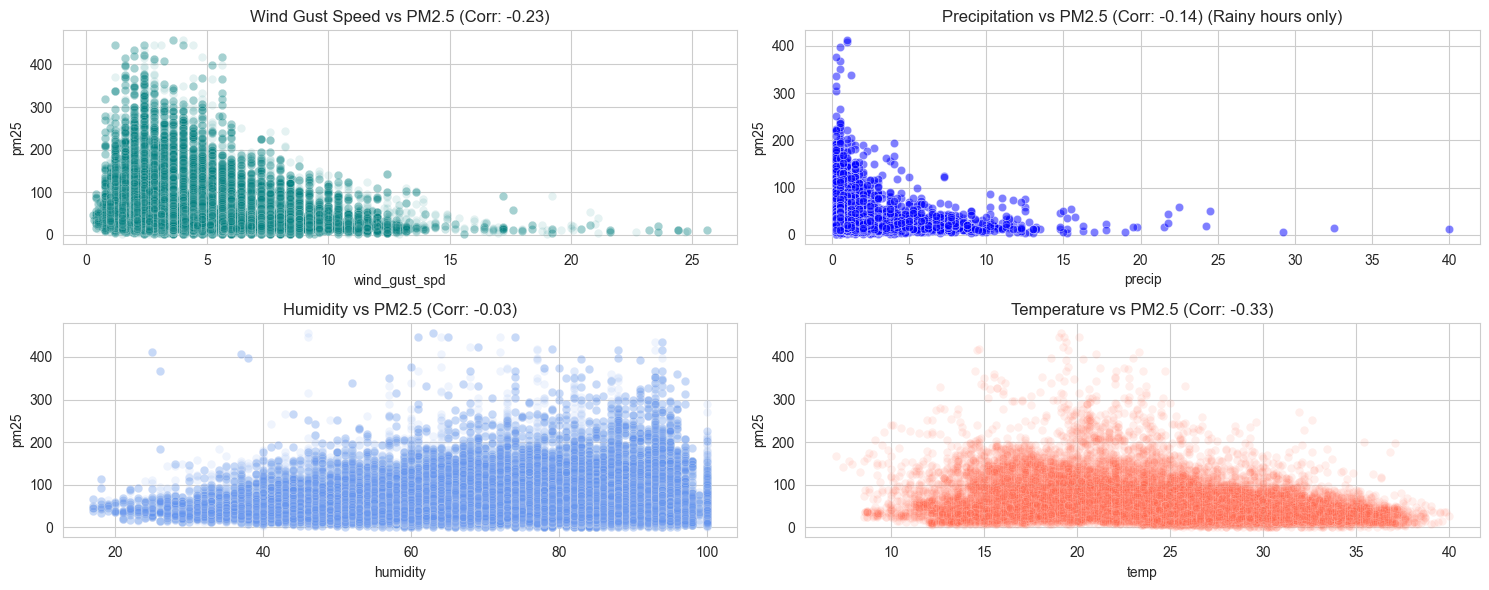

In [15]:
cols = ['pm25', 'aqi',
        'temp', 'pres', 'humidity', 'clouds',
        'wind_spd', 'wind_dir', 'wind_gust_spd', 'uv',
        'precip', 'dewpt',
        'pm10', 'o3', 'so2', 'no2', 'co']
corr_matrix = df_dhbk[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Pollutants vs Weather')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 6))
axes_flat = axes.ravel()

wind_corr = df_dhbk['wind_gust_spd'].corr(df_dhbk['pm25'])
sns.scatterplot(data=df, x='wind_gust_spd', y='pm25', alpha=0.1, ax=axes_flat[0], color='teal')
axes_flat[0].set_title(f"Wind Gust Speed vs PM2.5 (Corr: {wind_corr:.2f})")

rain_df = df_dhbk[df_dhbk['precip'] > 0]
rain_corr = rain_df['precip'].corr(rain_df['pm25'])
sns.scatterplot(data=rain_df, x='precip', y='pm25', alpha=0.5, ax=axes_flat[1], color='blue')
axes_flat[1].set_title(f"Precipitation vs PM2.5 (Corr: {rain_corr:.2f}) (Rainy hours only)")

hum_corr = df_dhbk['humidity'].corr(df_dhbk['pm25'])
sns.scatterplot(data=df, x='humidity', y='pm25', alpha=0.1, ax=axes_flat[2], color='cornflowerblue')
axes_flat[2].set_title(f"Humidity vs PM2.5 (Corr: {hum_corr:.2f})")

temp_corr = df_dhbk['temp'].corr(df_dhbk['pm25'])
sns.scatterplot(data=df_dhbk, x='temp', y='pm25', alpha=0.1, ax=axes_flat[3], color='tomato')
axes_flat[3].set_title(f"Temperature vs PM2.5 (Corr: {temp_corr:.2f})")

plt.tight_layout()
plt.show()

Observations:
- Use either `pm25` or `aqi` as target, drop the other to avoid leakage. It's better to use `pm25`, as `aqi` is a piecewise function from pollutant that's harder for regression models to learn smoothly. `pm25` and `aqi` have high correlation anyway, meaning most AQI values are derived from PM2.5.
- Some multicollinearity here and there. Keep if tree-based model (Random Forest, XGBoost), remove some if Linear Regression.
    - `temp`, `pres`, `dewpt`: maybe keep `temp` then `pres`.
    - `pm25`, `aqi`, `pm10`: keep one as target and remove others to avoid leakage.

Possible feature engineering:
- Correlation plot with Precipitation (rain) is quite sparse: Most data points have rain = 0.0. Those with positive values are not large enough in value and quantity to make real difference. -> Add boolean feature `is_raining`, hope it does something.
- MAYBE "lag" effect of weather: rain, wind, humidity, etc. takes some time (e.g. 1h) to reduce/raise pollutant conc. -> Create lag features.
- Wind direction is unusable as of now as it's not ordinal. -> Bin or convert to sin/cos values.

In [16]:
df['is_raining'] = df['precip'] > 0

lag_cols = ['temp', 'pres', 'humidity', 'clouds', 'wind_spd', 'wind_gust_spd', 'uv', 'precip', 'dewpt']
for c in lag_cols:
    df[f'{c}_lag1'] = df[c].shift(1)

print(df.columns)

Index(['lat', 'lon', 'timestamp', 'temp', 'pres', 'humidity', 'clouds',
       'wind_spd', 'wind_dir', 'wind_gust_spd', 'uv', 'precip', 'dewpt', 'aqi',
       'pm25', 'pm10', 'o3', 'so2', 'no2', 'co', 'hour', 'month',
       'day_of_week', 'is_weekend', 'aqi_category', 'is_raining', 'temp_lag1',
       'pres_lag1', 'humidity_lag1', 'clouds_lag1', 'wind_spd_lag1',
       'wind_gust_spd_lag1', 'uv_lag1', 'precip_lag1', 'dewpt_lag1'],
      dtype='object')


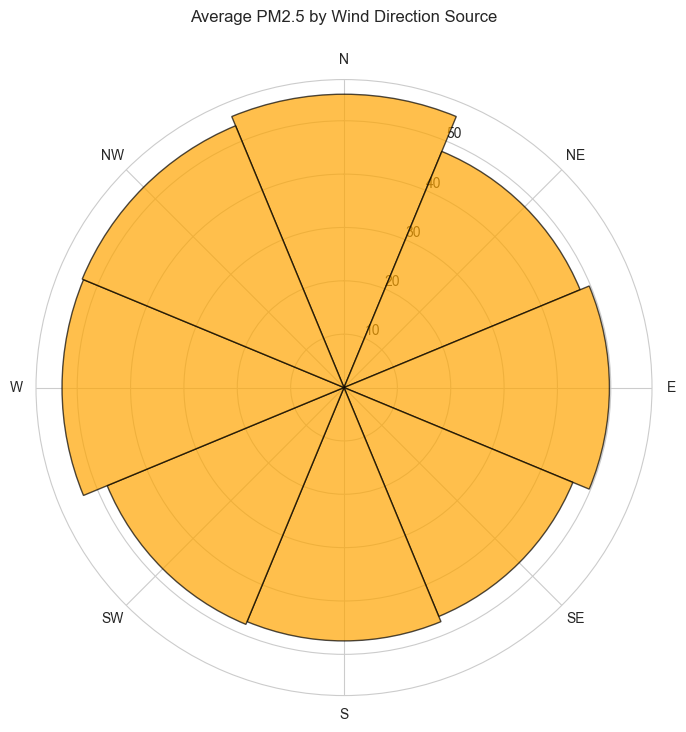

In [17]:
def wind_direction_to_sector(d):
    if pd.isna(d):
        return None
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ix = round(d / (360. / 8))
    return dirs[ix % 8]

df['wind_sector'] = df['wind_dir'].apply(wind_direction_to_sector)
df['wind_sin'] = df['wind_dir'].apply(lambda dir: math.sin(dir) if pd.notna(dir) else None)
df['wind_cos'] = df['wind_dir'].apply(lambda dir: math.cos(dir) if pd.notna(dir) else None)

# Calculate mean PM2.5 per sector
sector_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
sector_avg = df.groupby('wind_sector')['pm25'].mean().reindex(sector_order)

# Polar Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
theta = np.linspace(0.0, 2 * np.pi, len(sector_avg), endpoint=False)
width = (2*np.pi) / len(sector_avg)

# Rotate so North is at the top (standard map convention)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

bars = ax.bar(theta, sector_avg, width=width, bottom=0.0, color='orange', alpha=0.7, edgecolor='black')

ax.set_xticks(theta)
ax.set_xticklabels(sector_order)
plt.title("Average PM2.5 by Wind Direction Source", y=1.08)
plt.show()

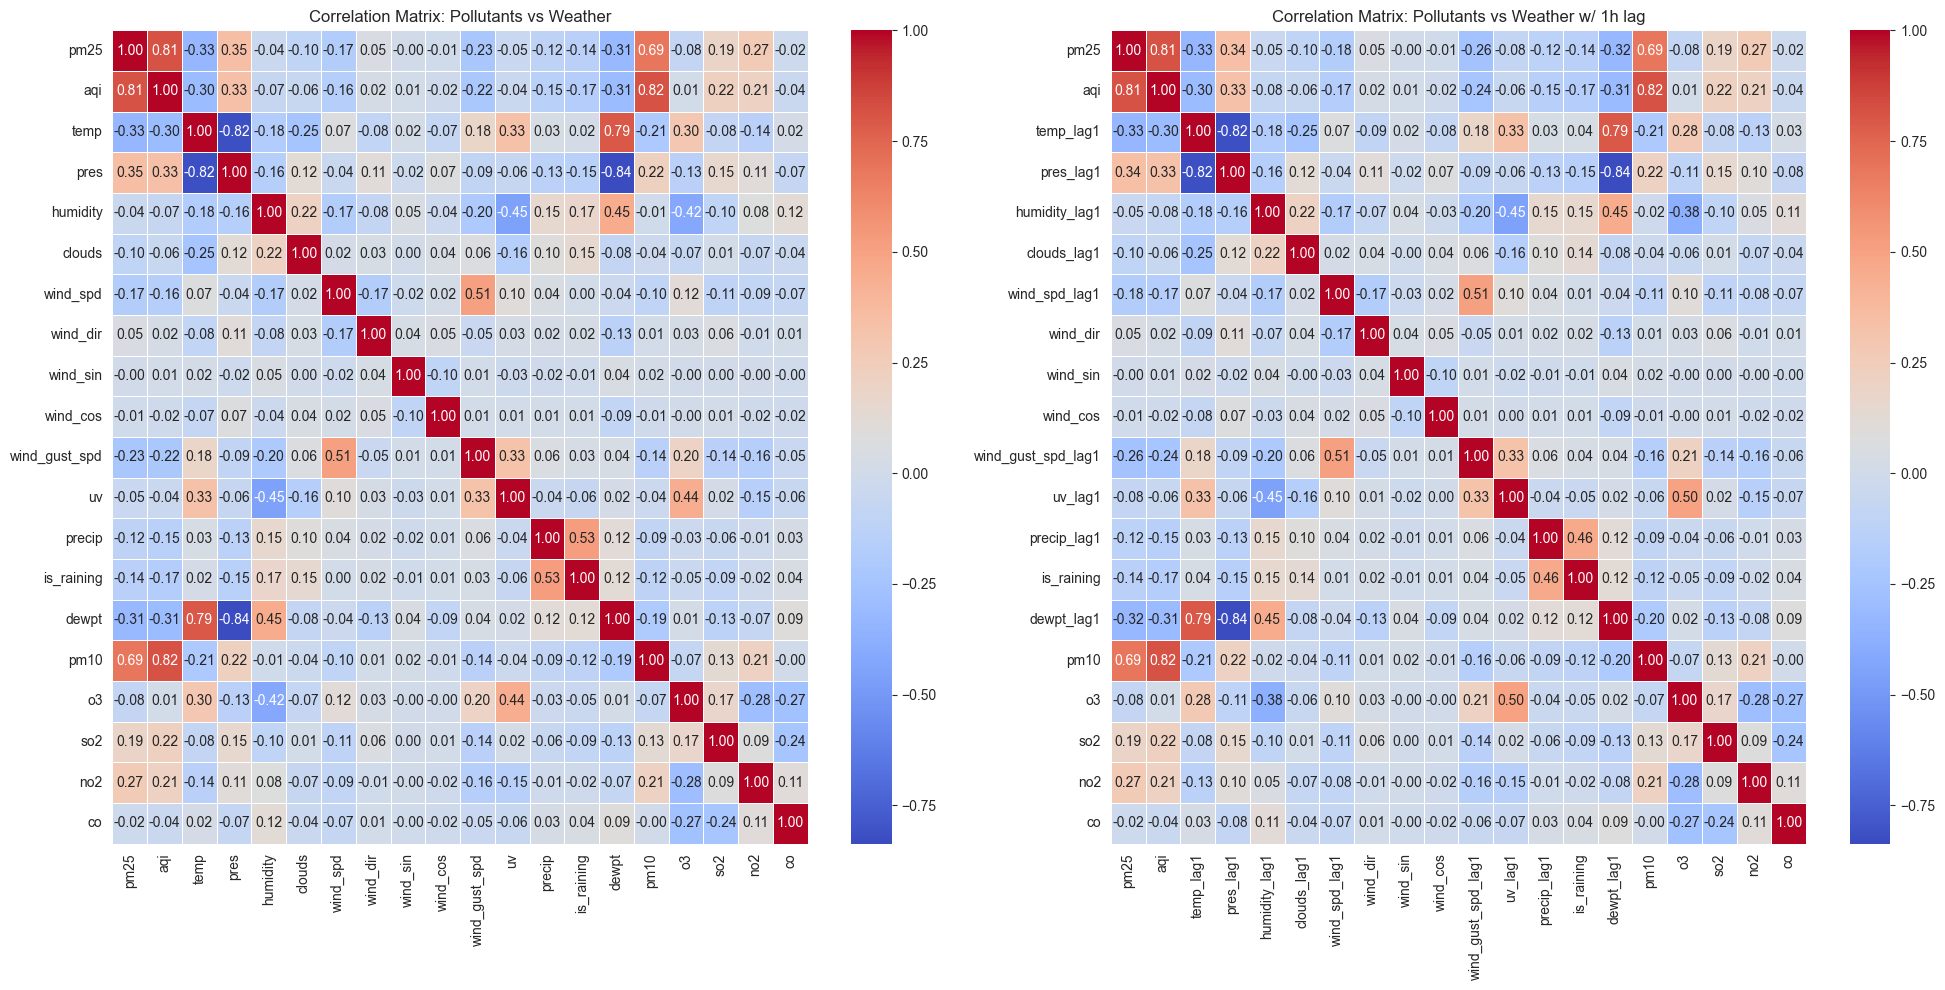

In [18]:
df_dhbk = df_loc_filtered(df, locs=[(21.00513, 105.841531)])

cols = ['pm25', 'aqi', 'temp', 'pres', 'humidity', 'clouds', 'wind_spd', 'wind_dir', 'wind_sin', 'wind_cos', 'wind_gust_spd', 'uv', 'precip', 'is_raining', 'dewpt', 'pm10', 'o3', 'so2', 'no2', 'co']
cols_enriched = ['pm25', 'aqi', 'temp_lag1', 'pres_lag1', 'humidity_lag1', 'clouds_lag1', 'wind_spd_lag1', 'wind_dir', 'wind_sin', 'wind_cos', 'wind_gust_spd_lag1', 'uv_lag1', 'precip_lag1', 'is_raining', 'dewpt_lag1', 'pm10', 'o3', 'so2', 'no2', 'co']

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

corr_matrix = df[cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], linewidths=0.5)
axes[0].set_title('Correlation Matrix: Pollutants vs Weather')

corr_matrix = df[cols_enriched].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], linewidths=0.5)
axes[1].set_title('Correlation Matrix: Pollutants vs Weather w/ 1h lag')

plt.tight_layout()
plt.show()

Bleh, not optimistic. No more `is_raining` and lagging features. Guess I'll keep all other weather features for redundancy.

In [19]:
df = df.drop(columns=['temp_lag1', 'pres_lag1', 'humidity_lag1', 'clouds_lag1', 'wind_spd_lag1', 'wind_gust_spd_lag1', 'uv_lag1', 'precip_lag1', 'is_raining', 'dewpt_lag1', 'is_weekend'])
print(df.columns)

Index(['lat', 'lon', 'timestamp', 'temp', 'pres', 'humidity', 'clouds',
       'wind_spd', 'wind_dir', 'wind_gust_spd', 'uv', 'precip', 'dewpt', 'aqi',
       'pm25', 'pm10', 'o3', 'so2', 'no2', 'co', 'hour', 'month',
       'day_of_week', 'aqi_category', 'wind_sector', 'wind_sin', 'wind_cos'],
      dtype='object')


In [20]:
# reorganize shits
df = df[['lat', 'lon',
         'timestamp', 'hour', 'month','day_of_week',
         'aqi','pm25', 'pm10', 'o3', 'so2', 'no2', 'co', 'aqi_category',
         'temp', 'pres', 'humidity', 'clouds','wind_spd', 'wind_dir', 'wind_sector', 'wind_sin','wind_cos', 'wind_gust_spd', 'uv', 'precip', 'dewpt']]

df.to_csv('data/weatherbit_final.csv', index=False)